In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import savemat
import math
from loading_real_wave_noise import loading_real_wave_noise
from Reading_path_test import loading_paths_from_MAT
from Control_filter_selection import Control_filter_selection
##from FxLMS_algorithm import FxLMS, train_fxlms_algorithm
from FxNLMS_algorithm import FxNLMS, train_fxnlms_algorithm
from Fixed_filter_noise_cancellation_v1 import Fixed_filter_controller
from Disturbance_generation import Disturbance_generation_from_real_noise
##from Combine_SFANC_with_FxLMS import SFANC_FxLMS
from Combine_SFANC_with_FxNLMS import SFANC_FxNLMS

print(torch.cuda.is_available())

True


In [10]:
# real noises
fs = 16000
StepSize = 0.002
sound_name = 'Mix_Aircraft_Traffic'
waveform, resample_rate = loading_real_wave_noise(folde_name='Real Noise Examples/', sound_name=sound_name+'.wav')

In [11]:
Pri_path, Secon_path = loading_paths_from_MAT(folder='', subfolder='Primary and Secondary Path', Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')
Dis, Fx, Re = Disturbance_generation_from_real_noise(fs=fs, Repet=0, wave_form=waveform, Pri_path=Pri_path, Sec_path=Secon_path)
# Dis: disturbance (cotrolled noise)， Fx: fixed-x signal, Re: repeated waveform (primary_noise) Repetition=Repet+1

In [12]:
print(waveform.shape)
print(Re.shape)
print(Dis.shape)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

torch.Size([1, 211107])
torch.Size([211107])
torch.Size([208000])


The primary nosie has 13 seconds !!!
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


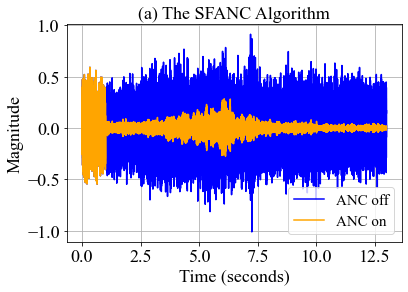

In [14]:
# SFANC

# prediction index
id_vector = Control_filter_selection(fs=16000, Primary_noise=Re.unsqueeze(0)) # Primary_noise: torch.Size([1, XX])

print(id_vector)
FILE_NAME_PATH = 'Trained models/Pretrained_Control_filters.mat'
Fixed_Cancellation = Fixed_filter_controller(MAT_FILE=FILE_NAME_PATH, fs=16000)
ErrorFixed = Fixed_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx, filter_index=id_vector)
Time = np.arange(len(Dis))*(1/fs)

plt.rc('font', size=18, family='Times New Roman') # 将plt画图时字号设置为9字体设置为Times New Roman
plt.rc('axes', titlesize=18) # fontsize of the axes title
plt.rc('axes', labelsize=18) # fontsize of the x and y labels
plt.rc('xtick', labelsize=18) # fontsize of the tick labels
plt.rc('ytick', labelsize=18) # fontsize of the tick labels
plt.rc('legend', fontsize=15) # legend fontsize
plt.rc('figure', titlesize=18) # fontsize of the figure title

plt.title('(a) The SFANC Algorithm')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorFixed, color='orange', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.savefig('SFANC.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

[========================================================================] 100%


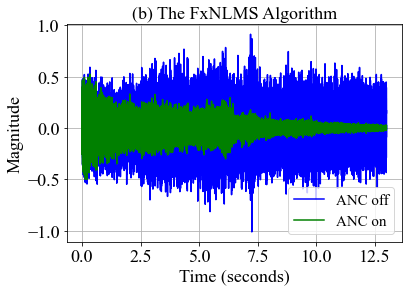

In [15]:
# FxNLMS

controller = FxNLMS(Len=1024) # 1024 is the same size of coeffient vector of fixed-filter
ErrorFxNLMS = train_fxnlms_algorithm(Model=controller, Ref=Fx, Disturbance=Dis, Stepsize=StepSize)

plt.title('(b) The FxNLMS Algorithm')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorFxNLMS, color='green', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.savefig('FxNLMS.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

The primary nosie has 13 seconds !!!
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


C:\Users\Liuzf\SFANC-FxNLMS-ANC-Algorithm-based-on-Deep-Learning-main\Combine_SFANC_with_FxNLMS.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Wc = torch.tensor(Ws, requires_grad=True) # Ws: initial coefficients determined by SFANC


0
change the initial weights of FxNLMS
1
2
3
4
5
6
7
8
9
10
11
12


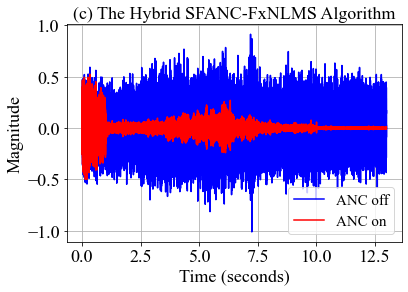

In [18]:
# Combine SFANC with FxNLMS

# prediction index
id_vector = Control_filter_selection(fs=16000, Primary_noise=Re.unsqueeze(0)) # Primary_noise: torch.Size([1, XX])
print(id_vector)

# Using prediction index in SFANC_FxNLMS
FILE_NAME_PATH = 'Trained models/Pretrained_Control_filters.mat'
SFANC_FxNLMS_Cancellation = SFANC_FxNLMS(MAT_FILE=FILE_NAME_PATH, fs=16000)
Error_SFANC_FxNLMS = SFANC_FxNLMS_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx, filter_index=id_vector, Stepsize=StepSize)

plt.title('(c) The Hybrid SFANC-FxNLMS Algorithm')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, Error_SFANC_FxNLMS, color='red', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.savefig('SFANC_FxNLMS.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

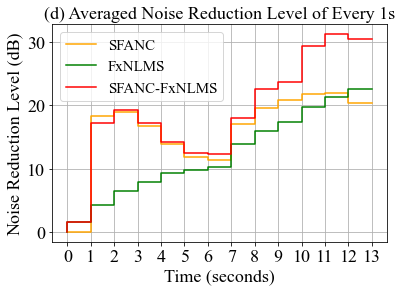

In [19]:
# compare the Noise_Reduction_Level in every second

def Noise_Reduction_Level_Compute(Disturbance, Error):
    Power_dis = 10*np.log10(np.var(Disturbance))
    Power_err = 10*np.log10(np.var(Error))
    NR_level = Power_dis - Power_err
    return NR_level

if torch.is_tensor(Dis):
    Dis = Dis.numpy() # tensor to numpy
if torch.is_tensor(ErrorFixed):
    ErrorFixed = ErrorFixed.numpy()

a, b, c = [], [], []
a.append(Dis[0])
b.append(Dis[0])
c.append(Dis[0])
Time1 = int(len(Dis)/fs)
for t in range(Time1):
    a.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], ErrorFixed[t*fs:(t+1)*fs]))
    b.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], ErrorFxNLMS[t*fs:(t+1)*fs]))
    c.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], Error_SFANC_FxNLMS[t*fs:(t+1)*fs]))
    
plt.title('(d) Averaged Noise Reduction Level of Every 1s')
plt.step(range(0,Time1+1), a, color='orange', label='SFANC')
plt.step(range(0,Time1+1), b, color='green', label='FxNLMS')
plt.step(range(0,Time1+1), c, color='red', label='SFANC-FxNLMS')
plt.ylabel('Noise Reduction Level (dB)')
plt.xlabel('Time (seconds)')
plt.xticks(range(0, Time1+1, 1)) # the interval in x
plt.legend()
plt.grid()
plt.savefig('Noise_Reduction_Level.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# if Pri_path, Secon_path are changed, Pre_trianing_control_filters need to be trained again
# %run Pre_trianing_control_filters.py